## Run default configurations
Print out Psats, NET, NET_wafer


In [71]:
# See what yaml files are locally available.
!ls *.yaml

CHLAT_20210605.yaml    SAT_LFMF_20210623.yaml SPLAT_20210605.yaml
CHLAT_20210714.yaml    SAT_LFMF_20210714.yaml SPLAT_20210714.yaml
SAT_HF_20210623.yaml   SAT_pole_20210605.yaml
SAT_HF_20210714.yaml   SAT_pole_20210623.yaml


In [24]:
# Standard imports
import numpy as np
import yaml
import toml
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline  
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 20]

# bolo-calc import
from bolo import Top



## Run
Read yaml files, run bolo_calc, store some outputs into dictionary called "data".
Print some outputs to table.

In [78]:
data = {}

yamlfiles = ['CHLAT_20210714.yaml']#,
#yamlfiles = ['SPLAT_20210714.yaml'] #,'SAT_LFMF_20210714.yaml','SAT_HF_20210714.yaml']
#yamlfiles = ['SAT_LFMF_20210714.yaml']
#yamlfiles = ['SAT_HF_20210714.yaml']


#read fixed PSATs from .toml file
psat_dict = toml.load("FixedPsats.toml")

for yamlfile in yamlfiles:
    print(yamlfile)
    data[yamlfile] = {}
    dd = yaml.safe_load(open(yamlfile))
    version_date = str(dd['version']['date'])
    version_telescope = str(dd['version']['name'])
    print('{0:8s}  Popt(pW) Psat(pW)   NET   corr_fac NET_wafer   NEP_photon NEP_photon_corr'.format(version_telescope))
    del dd['version']

    # location of atmosphere file
    dd['sim_config']['config_dir'] = '../../bolo-calc/config'
    
    ch_names = list(dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'].keys())
    
    #---------
    #convert to Watts
    for channel in ch_names:
        psat_dict[yamlfile.partition('.')[0]][channel] *= 1e-12

    #set psat factor to None & delete psat entry from channel default
    dd['instrument']['channel_default']['psat_factor'] = None
    del dd['instrument']['channel_default']['psat']

    #assign SI psat values at the channel level
    for channel in ch_names:
        dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][channel]['psat'] = psat_dict[yamlfile.partition('.')[0]][channel]
    #---------
    
    # Save some of the defaults things
    data[yamlfile]['defaults']={}
    data[yamlfile]['defaults']['Yield']=dd['instrument']['channel_default']['Yield']
    data[yamlfile]['defaults']['Tc']=dd['instrument']['channel_default']['Tc']
    data[yamlfile]['defaults']['waist_factor']=dd['instrument']['channel_default']['waist_factor']
    data[yamlfile]['defaults']['read_frac']=dd['instrument']['channel_default']['read_frac']
    data[yamlfile]['defaults']['site']=dd['instrument']['site']
    data[yamlfile]['defaults']['elevation']=dd['instrument']['elevation']
    data[yamlfile]['defaults']['pwv']=dd['instrument']['pwv']

    top = Top(**dd)
    top.run()
    
    for chan in top.instrument.tables.keys():
        if chan.split('_')[0] == 'cam' :
            chname = chan.split('_')[2] + '_' + chan.split('_')[3]
            data[yamlfile][chname] = {}
            #
            # Grab things we're going to print and give them short names and store them in the dictionary.
            popt = top.instrument.tables[chan]['opt_power'][0]
            data[yamlfile][chname]['popt'] = popt
            psat = top.instrument.tables[chan]['P_sat'][0]
            data[yamlfile][chname]['psat'] = psat
            net = top.instrument.tables[chan]['NET'][0]
            data[yamlfile][chname]['net'] = net
            netwafer = top.instrument.tables[chan]['NET_arr'][0]
            data[yamlfile][chname]['netwafer'] = netwafer
            #
            # Grab things we're not going to print and store them in the dictionary.
            data[yamlfile][chname]['effic'] = top.instrument.tables[chan]['effic'][0]
            data[yamlfile][chname]['nep_photon'] = top.instrument.tables[chan]['NEP_ph'][0]
            data[yamlfile][chname]['nep_phonon'] = top.instrument.tables[chan]['NEP_bolo'][0]
            data[yamlfile][chname]['nep_readout'] = top.instrument.tables[chan]['NEP_read'][0]
            data[yamlfile][chname]['Gdyn'] = top.instrument.tables[chan]['G'][0]
            data[yamlfile][chname]['corr_fact'] = top.instrument.tables[chan]['corr_fact'][0]
            data[yamlfile][chname]['bandcenter'] = dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][chname]['band_center']
            data[yamlfile][chname]['fractional_bandwidth'] = dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][chname]['fractional_bandwidth']
            dnu = 0.5*data[yamlfile][chname]['bandcenter']*data[yamlfile][chname]['fractional_bandwidth']
            data[yamlfile][chname]['band_lowedge'] = data[yamlfile][chname]['bandcenter'] - dnu
            data[yamlfile][chname]['band_highedge'] = data[yamlfile][chname]['bandcenter'] + dnu
            print('{0:5s} : {1:8.3f} {2:8.2f} {3:8.2f} {4:8.3f} {5:8.2f} {6:8.2f} {7:8.2f}'.format(chname,popt,psat,net,top.instrument.tables[chan]['corr_fact'][0],netwafer,top.instrument.tables[chan]['NEP_ph'][0],top.instrument.tables[chan]['NEP_ph_corr'][0]) )
    print(' ')
    

CHLAT_20210714.yaml
CHLAT     Popt(pW) Psat(pW)   NET   corr_fac NET_wafer   NEP_photon NEP_photon_corr
LF_1  :    0.271     0.75   314.22    1.281    35.85     5.18     7.53
LF_2  :    1.372     4.18   255.58    1.039    29.16    18.00    18.99
MF_1  :    1.559     4.60   291.47    1.149    11.09    18.97    22.83
MF_2  :    4.731    12.51   327.50    1.015    12.46    45.46    46.30
HF_1  :   12.517    31.70   740.33    1.008    27.03    96.33    97.22
HF_2  :   17.016    42.43  1850.19    1.007    67.54   128.59   129.59
 


In [73]:
top.instrument.tables['cam_1_HF_2_sims']

effic,opt_power,P_sat,Flink,G,tel_rj_temp,sky_rj_temp,NEP_bolo,NEP_read,NEP_ph,NEP_ph_corr,NEP,NET,NET_corr,corr_fact,NET_arr
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.38628949982479255,16.2482577857804,40.621,0.5240505937739165,1139.5770813556937,29.86743916292655,40.85094052396689,29.05643808118748,40.54828042393588,123.27342975071224,123.58557675501933,132.98412733032393,1747.1528702530509,1750.9550893265996,1.0021762372018415,63.77999683113989


In [74]:
top.instrument.tables['optical']

elem_effic_mean,elem_effic_median,elem_effic_std,elem_effic_n_2_sig,elem_effic_n_1_sig,elem_effic_p_1_sig,elem_effic_p_2_sig,elem_cumul_effic_mean,elem_cumul_effic_median,elem_cumul_effic_std,elem_cumul_effic_n_2_sig,elem_cumul_effic_n_1_sig,elem_cumul_effic_p_1_sig,elem_cumul_effic_p_2_sig,elem_power_from_sky_mean,elem_power_from_sky_median,elem_power_from_sky_std,elem_power_from_sky_n_2_sig,elem_power_from_sky_n_1_sig,elem_power_from_sky_p_1_sig,elem_power_from_sky_p_2_sig,elem_power_to_det_mean,elem_power_to_det_median,elem_power_to_det_std,elem_power_to_det_n_2_sig,elem_power_to_det_n_1_sig,elem_power_to_det_p_1_sig,elem_power_to_det_p_2_sig,element,channel
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str12,str7
1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.4302773145964966,0.4302773145964966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07200198898411314,0.07200198898411314,0.0,0.0,0.0,0.0,0.0,cmb,cam_1_0
1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.4302773145964966,0.4302773145964966,0.0,0.0,0.0,0.0,0.0,1.2824445337370804e-14,1.2824445337370804e-14,0.0,0.0,0.0,0.0,0.0,5.5176143804721444e-15,5.5176143804721444e-15,0.0,0.0,0.0,0.0,0.0,dust,cam_1_0
1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.4302773145964966,0.4302773145964966,0.0,0.0,0.0,0.0,0.0,1.0853036648153524e-13,1.0853036648153524e-13,0.0,0.0,0.0,0.0,0.0,4.11826544261421e-14,4.11826544261421e-14,0.0,0.0,0.0,0.0,0.0,synchrotron,cam_1_0
0.9464398800370454,0.9464398800370454,0.0,0.0,0.0,0.0,0.0,0.4546513633565169,0.4546513633565169,0.0,0.0,0.0,0.0,0.0,9.517357570465178,9.517357570465178,0.0,0.0,0.0,0.0,0.0,4.330874615944832,4.330874615944832,0.0,0.0,0.0,0.0,0.0,atmosphere,cam_1_0
0.9899999999999914,0.9899999999999914,0.0,0.0,0.0,0.0,0.0,0.4592438013702185,0.4592438013702185,0.0,0.0,0.0,0.0,0.0,11.009161306799017,11.009161306799017,0.0,0.0,0.0,0.0,0.0,0.9859178571851459,0.9859178571851459,0.0,0.0,0.0,0.0,0.0,baffle,cam_1_0
0.9274315235162751,0.9274315235162751,0.0,0.0,0.0,0.0,0.0,0.4952068018897811,0.4952068018897811,0.0,0.0,0.0,0.0,0.0,24.33016799206874,24.33016799206874,0.0,0.0,0.0,0.0,0.0,6.724004976003351,6.724004976003351,0.0,0.0,0.0,0.0,0.0,window,cam_1_0
0.9956499999999945,0.9956499999999945,0.0,0.0,0.0,0.0,0.0,0.4973703629686953,0.4973703629686953,0.0,0.0,0.0,0.0,0.0,23.023538933979996,23.023538933979996,0.0,0.0,0.0,0.0,0.0,0.25102320159647484,0.25102320159647484,0.0,0.0,0.0,0.0,0.0,RTMLI_10,cam_1_0
0.9375897936799006,0.9375897936799006,0.0,0.0,0.0,0.0,0.0,0.5305040459872424,0.5305040459872424,0.0,0.0,0.0,0.0,0.0,24.469456605609608,24.469456605609608,0.0,0.0,0.0,0.0,0.0,0.8245855394362664,0.8245855394362664,0.0,0.0,0.0,0.0,0.0,alumina_filt,cam_1_0
0.9208980000000017,0.9208980000000017,0.0,0.0,0.0,0.0,0.0,0.5760725357067142,0.5760725357067142,0.0,0.0,0.0,0.0,0.0,22.977137629608162,22.977137629608162,0.0,0.0,0.0,0.0,0.0,0.024851409120677126,0.024851409120677126,0.0,0.0,0.0,0.0,0.0,nylon_filt,cam_1_0


In [75]:
elems = 0*14 + np.arange(0,14)
print(top.instrument.tables['optical']['element'][elems])
print(top.instrument.tables['optical']['elem_power_to_det_mean'][elems])


  element   
------------
         cmb
        dust
 synchrotron
  atmosphere
      baffle
      window
    RTMLI_10
alumina_filt
  nylon_filt
       lens1
    aperture
       lens2
     lowpass
    detector
elem_power_to_det_mean
----------------------
   0.07200198898411314
5.5176143804721444e-15
  4.11826544261421e-14
     4.330874615944832
    0.9859178571851459
     6.724004976003351
   0.25102320159647484
    0.8245855394362664
  0.024851409120677126
 9.398019511114074e-07
 5.582622684484288e-06
 1.009510021986802e-06
1.1954367078418617e-44
                   0.0


## Make a 4-panel plot.
Popt, Psat, NET, NET_wafer

Text(0.5, 1.0, '20210714')

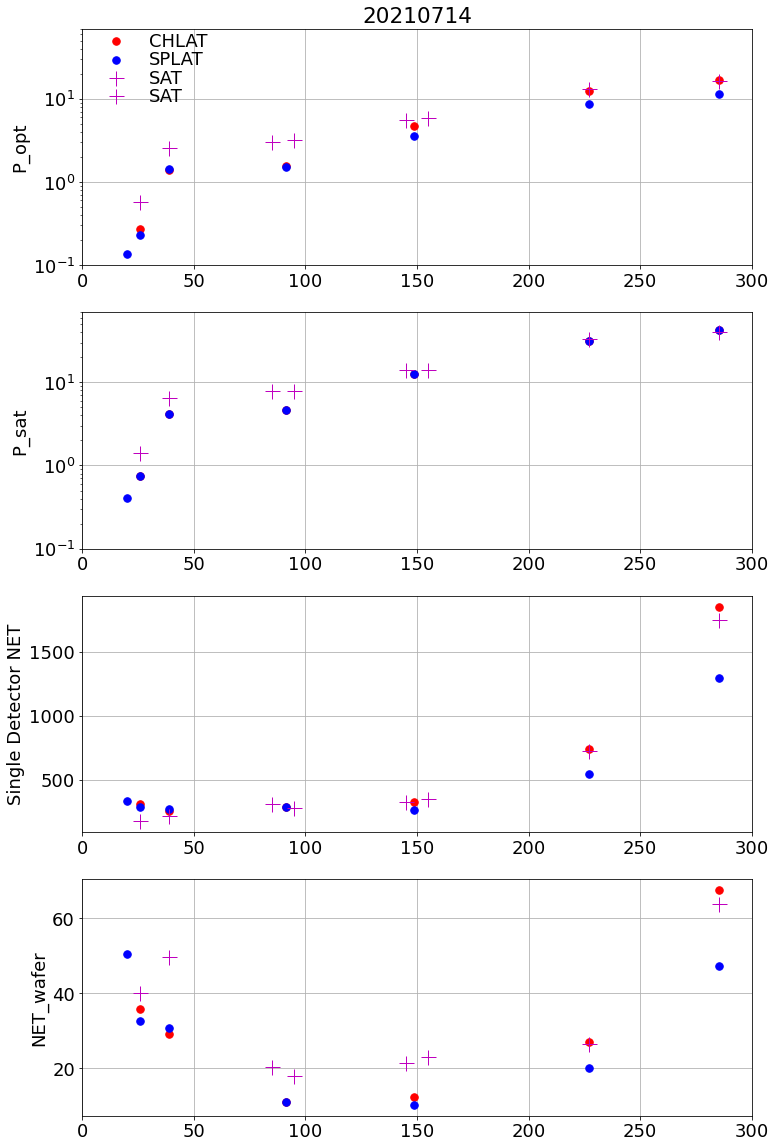

In [11]:
# Plot things vs frequency for each telescope

# Set up a 4-panel plot
plt.clf()
ax1=plt.subplot(4,1,1)
ax1.set_ylabel('P_opt')
ax1.set_xlim(0,300)
ax1.set_ylim(0.1,70)
ax1.grid()
#
ax2=plt.subplot(4,1,2)
ax2.set_ylabel('P_sat')
ax2.set_xlim(0,300)
ax2.set_ylim(0.1,70)
ax2.grid()
#
ax3=plt.subplot(4,1,3)
ax3.set_ylabel('Single Detector NET')
ax3.set_xlim(0,300)
ax3.grid()
#
ax4=plt.subplot(4,1,4)
ax4.set_ylabel('NET_wafer')
ax4.set_xlim(0,300)
ax4.grid()
yfrac = 0.7

for yamlfile in yamlfiles: 
    telescope = yamlfile.split('_')[0]
    if telescope == 'CHLAT':
        pointtype = '.r'
    elif telescope == 'SPLAT':
        pointtype = '.b'
    else:
        pointtype = '+m'
    
    for chname in data[yamlfile].keys():
        if chname != 'defaults':
            nu = data[yamlfile][chname]['bandcenter']
            #
            ax1.semilogy(nu, data[yamlfile][chname]['popt'],pointtype, markersize=15 )
            ax2.semilogy(nu, data[yamlfile][chname]['psat'],pointtype, markersize=15 )
            ax3.plot(nu, data[yamlfile][chname]['net'],pointtype, markersize=15 )
            ax4.plot(nu, data[yamlfile][chname]['netwafer'],pointtype, markersize=15 )
            #
    
    ymin,ymax = ax1.set_ylim()
    xmin,xmax = ax1.set_xlim()
    xval = xmin+0.05*(xmax-xmin)
    yval = ymin+yfrac*(ymax-ymin)
    ax1.semilogy(xval,yval,pointtype,markersize=15)
    ax1.text(xval+0.05*(xmax-xmin),yval,telescope,verticalalignment='center')
    yfrac = yfrac*0.6


ax1.grid()
ax1.grid()
ax1.set_title(version_date)
    

## Make a 4-panel plot.
efficiency, NEP_photon, NEP_phonon, NEP_readout

Text(0.5, 1.0, '20210714')

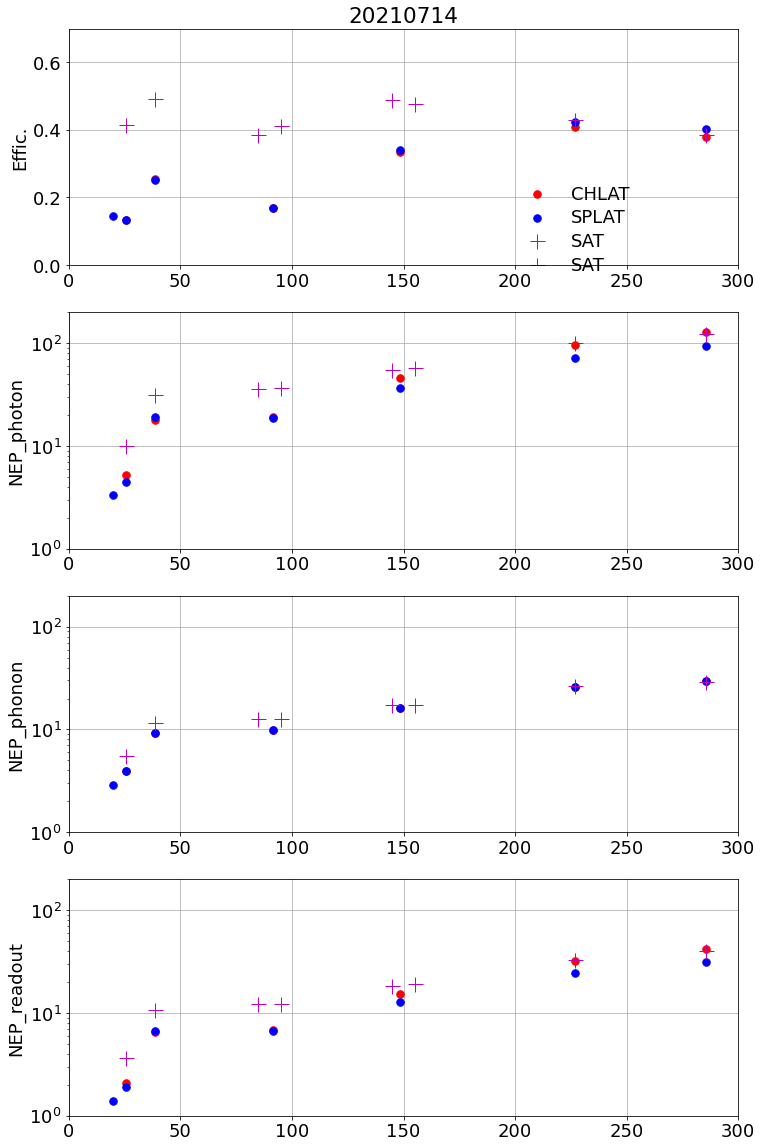

In [12]:
plt.clf()
ax1=plt.subplot(4,1,1)
ax1.set_ylabel('Effic.')
ax1.set_xlim(0,300)
ax1.set_ylim(0,0.7)
ax1.grid()
#
ax2=plt.subplot(4,1,2)
ax2.set_ylabel('NEP_photon')
ax2.set_xlim(0,300)
ax2.set_ylim(1,200)
ax2.grid()
#
ax3=plt.subplot(4,1,3)
ax3.set_ylabel('NEP_phonon')
ax3.set_xlim(0,300)
ax3.set_ylim(1,200)
ax3.grid()
#
ax4=plt.subplot(4,1,4)
ax4.set_ylabel('NEP_readout')
ax4.set_xlim(0,300)
ax4.set_ylim(1,200)
ax4.grid()

#data = {}
yfrac = 0.3

for yamlfile in yamlfiles: 
    telescope = yamlfile.split('_')[0]
    if telescope == 'CHLAT':
        pointtype = '.r'
    elif telescope == 'SPLAT':
        pointtype = '.b'
    else:
        pointtype = '+m'
    
    for chname in data[yamlfile].keys():
        if chname != 'defaults':
            nu = data[yamlfile][chname]['bandcenter']
            #
            ax1.plot(nu, data[yamlfile][chname]['effic'],pointtype, markersize=15 )
            ax2.semilogy(nu, data[yamlfile][chname]['nep_photon'],pointtype, markersize=15 )
            ax3.semilogy(nu, data[yamlfile][chname]['nep_phonon'],pointtype, markersize=15 )
            ax4.semilogy(nu, data[yamlfile][chname]['nep_readout'],pointtype, markersize=15 )

    
    ymin,ymax = ax1.set_ylim()
    xmin,xmax = ax1.set_xlim()
    xval = xmin+0.7*(xmax-xmin)
    yval = ymin+yfrac*(ymax-ymin)
    ax1.plot(xval,yval,pointtype,markersize=15)
    ax1.text(xval+0.05*(xmax-xmin),yval,telescope,verticalalignment='center')
    yfrac = yfrac-0.1


ax1.grid()
ax1.grid()
ax1.set_title(version_date)



In [8]:
# Write to files
data['runtime'] = datetime.today().strftime('%Y/%m/%d %H:%M:%S')
data['input_id'] = version_date
data['variation'] = 'BaseModel'

# Write to toml file
output_file_name = data['variation'] + '.toml'
with open('outputs/' + output_file_name, "w") as toml_file:
    toml.dump(data, toml_file, encoder=toml.TomlNumpyEncoder())

## Notes
Key lists etc.

In [ ]:
data2 = {}
data2['SAT_pole_20210401'] = {'LF_1': 1.40, 'LF_2': 6.13, 'MF1_1': 7.40, 'MF1_2': 12.25, 'MF2_1': 7.65, 'MF2_2': 13.30, 'UHF_1': 29.88, 'UHF_2': 39.03}
data2['SPLAT_20210401'] = {'ULF': 0.42, 'LF_1': 0.69, 'LF_2': 4.32, 'MF_1': 4.65, 'MF_2': 11.49, 'UHF_1': 29.31, 'UHF_2': 40.02}
data2['CHLAT_20210401'] = {'LF_1': 0.72, 'LF_2': 3.84, 'MF_1': 4.47, 'MF_2': 13.95, 'UHF_1': 41.52, 'UHF_2': 60.78}

# Write to toml file
with open('FixedPsats.toml', "w") as toml_file:
    toml.dump(data2, toml_file, encoder=toml.TomlNumpyEncoder())

In [ ]:
top.instrument.tables.keys()

In [ ]:
data[yamlfile][chname]['Gdyn']